In [14]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import math
import copy

from torch.utils.data import DataLoader

In [15]:
d_model = 512
droput = 0.1
max_len = 60

In [16]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


input = torch.tensor([[1, 2, 4, 5], [4, 3, 2, 9]])
embedding = Embeddings(d_model, 1000)
output = embedding(input)
print(output.size())

pe = PositionalEncoding(d_model, droput, max_len)
pe_result = pe(output)
print(pe_result)
print(pe_result.size())

torch.Size([2, 4, 512])
tensor([[[ -2.9324, -15.7043,  44.8671,  ...,  31.5619,   7.8078, -12.6288],
         [ 28.4021, -39.4196, -11.4273,  ...,  42.1053, -28.8644,  -4.1344],
         [  3.0865, -20.2727,  -0.0000,  ...,  34.2031, -21.7667,  17.8716],
         [-21.1955,  15.6839,   9.6901,  ...,   0.6914,  30.6584,  41.1130]],

        [[  2.0762, -18.6992,  -9.4986,  ...,  34.2031, -21.7669,  17.8716],
         [-36.2124,   2.1096, -14.2177,  ...,  -5.0156,  -7.7716,   7.8088],
         [  0.0000, -40.4823, -11.3001,  ...,  42.1053,  -0.0000,  -4.1344],
         [ 24.8308, -14.7862,  -0.0000,  ..., -10.1753,  -0.0000,   6.0161]]],
       grad_fn=<MulBackward0>)
torch.Size([2, 4, 512])


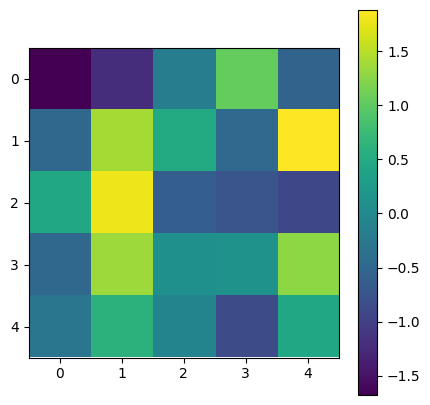

In [17]:
input = torch.randn(5, 5)
plt.figure(figsize=(5, 5))
plt.imshow(input)
plt.colorbar()
plt.show()

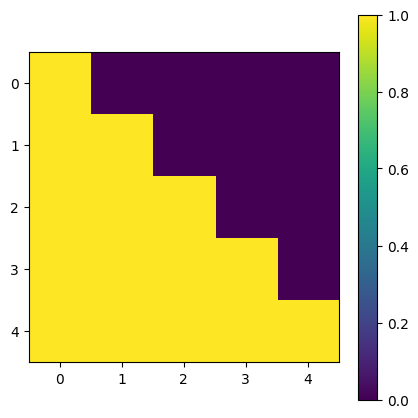

In [18]:
def subsequent_mask(sz):
    attn_shape = (1, sz, sz)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(1 - subsequent_mask)


seq_mask = subsequent_mask(5)
plt.figure(figsize=(5, 5))
plt.imshow(seq_mask[0])
plt.colorbar()
plt.show()

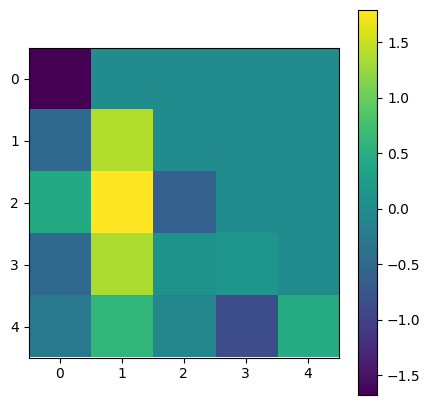

In [19]:
masked_input = input.masked_fill(seq_mask[0] == 0, 1e-9)
plt.figure(figsize=(5, 5))
plt.imshow(masked_input)
plt.colorbar()
plt.show()

In [20]:
def attention(q, k, v, mask=None, dropout=None):
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_atten = torch.softmax(scores, dim=-1)
    if dropout is not None:
        p_atten = dropout(p_atten)
    return torch.matmul(p_atten, v), p_atten


query = key = value = pe_result
atten, p_atten = attention(query, key, value)

print(f"atten: {atten}")
print(f"p_atten: {p_atten}")

atten: tensor([[[ -2.9324, -15.7043,  44.8671,  ...,  31.5619,   7.8078, -12.6288],
         [ 28.4021, -39.4196, -11.4273,  ...,  42.1053, -28.8644,  -4.1344],
         [  3.0865, -20.2727,   0.0000,  ...,  34.2031, -21.7667,  17.8716],
         [-21.1955,  15.6839,   9.6901,  ...,   0.6914,  30.6584,  41.1130]],

        [[  2.0762, -18.6992,  -9.4986,  ...,  34.2031, -21.7669,  17.8716],
         [-36.2124,   2.1096, -14.2177,  ...,  -5.0156,  -7.7716,   7.8088],
         [  0.0000, -40.4823, -11.3001,  ...,  42.1053,   0.0000,  -4.1344],
         [ 24.8308, -14.7862,   0.0000,  ..., -10.1753,   0.0000,   6.0161]]],
       grad_fn=<UnsafeViewBackward0>)
p_atten: tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], grad_fn=<SoftmaxBackward0>)


In [21]:
mask = torch.zeros(4, 4)
atten, p_atten = attention(query, key, value, mask=mask)
print(f"atten: {atten}")
print(f"p_atten: {p_atten}")

atten: tensor([[[  1.8402, -14.9282,  10.7825,  ...,  27.1404,  -3.0412,  10.5554],
         [  1.8402, -14.9282,  10.7825,  ...,  27.1404,  -3.0412,  10.5554],
         [  1.8402, -14.9282,  10.7825,  ...,  27.1404,  -3.0412,  10.5554],
         [  1.8402, -14.9282,  10.7825,  ...,  27.1404,  -3.0412,  10.5554]],

        [[ -2.3263, -17.9645,  -8.7541,  ...,  15.2794,  -7.3846,   6.8905],
         [ -2.3263, -17.9645,  -8.7541,  ...,  15.2794,  -7.3846,   6.8905],
         [ -2.3263, -17.9645,  -8.7541,  ...,  15.2794,  -7.3846,   6.8905],
         [ -2.3263, -17.9645,  -8.7541,  ...,  15.2794,  -7.3846,   6.8905]]],
       grad_fn=<UnsafeViewBackward0>)
p_atten: tensor([[[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.250

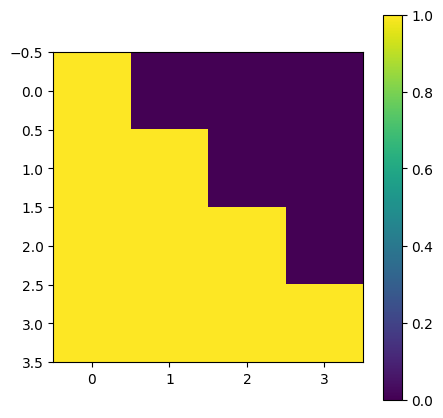

atten: tensor([[[ -2.9324, -15.7043,  44.8671,  ...,  31.5619,   7.8078, -12.6288],
         [ 28.4021, -39.4196, -11.4273,  ...,  42.1053, -28.8644,  -4.1344],
         [  3.0865, -20.2727,   0.0000,  ...,  34.2031, -21.7667,  17.8716],
         [-21.1955,  15.6839,   9.6901,  ...,   0.6914,  30.6584,  41.1130]],

        [[  2.0762, -18.6992,  -9.4986,  ...,  34.2031, -21.7669,  17.8716],
         [-36.2124,   2.1096, -14.2177,  ...,  -5.0156,  -7.7716,   7.8088],
         [  0.0000, -40.4823, -11.3001,  ...,  42.1053,   0.0000,  -4.1344],
         [ 24.8308, -14.7862,   0.0000,  ..., -10.1753,   0.0000,   6.0161]]],
       grad_fn=<UnsafeViewBackward0>)
p_atten: tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], grad_fn=<SoftmaxBackward0>)


In [22]:
mask = subsequent_mask(4)
plt.figure(figsize=(5, 5))
plt.imshow(mask[0])
plt.colorbar()
plt.show()

atten, p_atten = attention(query, key, value, mask=mask)
print(f"atten: {atten}")
print(f"p_atten: {p_atten}")

In [23]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()

        assert d_model % num_heads == 0

        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        # 需要4个线性连接层，前三个分别用于qkv，最后一个用于全连接层
        self.linears = clones(nn.Linear(d_model, d_model), 4)

        self.atten = None
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        # 如果存在掩码张量，对mask进行扩展，代表第n个头
        if mask is not None:
            mask = mask.unsqueeze(1)

        # 获取batch_size, 是query的第1个数据，代表有多少个样本
        batch_size = q.shape[0]
        query, key, value = [model(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2) for model, x in
                             zip(self.linears, (q, k, v))]

        x, self.atten = attention(query, key, value, mask=self.atten, dropout=self.dropout)

        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)

        return self.linears[-1](x)


multihead_attention = MultiHeadAttention(d_model, num_heads=8, dropout=droput)
output = multihead_attention(query, key, value, mask=mask)

In [24]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        """
        d_model 是线性层输入的维度
        d_ff 是中间层的维度
        Positionwise 表示输入输出维度大小一致
        """
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w2(self.dropout(torch.relu(self.w1(x))))


d_model = 512
d_ff = 64
dropout = 0.2

ff = PositionwiseFeedForward(d_model, d_ff, dropout)
ff_result = ff(output)
print(ff_result)
print(ff_result.size())

tensor([[[ 2.2853,  1.4459,  0.3443,  ..., -0.9125, -2.0264, -1.9215],
         [ 0.3441, -0.8290, -1.1934,  ..., -2.4143, -1.6420,  1.6441],
         [-0.1992,  1.3493, -2.5746,  ..., -0.1596,  0.4340,  0.0694],
         [-0.8955,  2.9592, -0.4299,  ..., -0.6034, -4.4925, -0.0493]],

        [[ 1.1869,  2.0791, -3.3511,  ...,  1.6263, -1.3607, -1.8419],
         [-0.8506, -4.4175, -1.4859,  ..., -0.5508, -2.8907,  0.1972],
         [ 3.8706, -0.5171, -1.4509,  ..., -5.6024, -2.2767,  2.1974],
         [-1.7427, -0.6551, -0.9044,  ..., -1.8734,  0.3255, -2.8059]]],
       grad_fn=<ViewBackward0>)
torch.Size([2, 4, 512])


In [25]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        """
        d_model 表示词嵌入的维度
        eps 是一个很小的数，防止除0的问题
        """
        super(LayerNorm, self).__init__()

        # 跟据词嵌入的维度定义a2和b2，一个全是1，一个全是0，用nn.parameter封装，表示为模型参数，在训练的时候进行更新
        self.a = nn.Parameter(torch.ones(d_model))
        self.b = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # * 表示同型点乘，即表示对应位置的乘法，加法表示对应位置加法
        return self.a * (x - mean) / (std + self.eps) + self.b


norm = LayerNorm(d_model)
norm_result = norm(ff_result)
print(norm_result)
print(norm_result.size())

tensor([[[ 1.1821,  0.7413,  0.1628,  ..., -0.4972, -1.0821, -1.0270],
         [ 0.2518, -0.5101, -0.7468,  ..., -1.5397, -1.0381,  1.0960],
         [-0.0229,  0.6084, -0.9912,  ..., -0.0067,  0.2353,  0.0866],
         [-0.4377,  1.4886, -0.2050,  ..., -0.2917, -2.2352, -0.0148]],

        [[ 0.4732,  0.8148, -1.2646,  ...,  0.6415, -0.5024, -0.6867],
         [-0.3586, -1.8017, -0.6156,  ..., -0.2373, -1.1840,  0.0654],
         [ 1.6164, -0.2014, -0.5882,  ..., -2.3081, -0.9304,  0.9232],
         [-0.8530, -0.3043, -0.4301,  ..., -0.9189,  0.1904, -1.3893]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


In [26]:
class SublayerConnection(nn.Module):
    def __init__(self, d_model, dropout = 0.1):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        # The original Transformer paper ("Attention Is All You Need") used post-norm. At the time, transformers were not as deep (6-12 layers), and training stability wasn't as much of a concern.
        # Transformer architectures like GPT-3 and many modern language models use pre-norm to address training stability issues, especially when scaling to large depths or widths.
        return x + self.dropout(sublayer(self.norm(x)))

In [31]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, self_atten, feed_forward, dropout=0.1):
        super(EncoderLayer, self).__init__()

        self.self_atten = self_atten
        self.feed_forward = feed_forward

        self.sublayers = clones(SublayerConnection(d_model, dropout), 2)
        self.d_model = d_model

    def forward(self, x, mask):
        x = self.sublayers[0](x, lambda x: self_atten(x, x, x, mask))
        return self.sublayers[1](x, self.feed_forward)


x = pe_result
mask = torch.zeros(4, 4)
self_atten = MultiHeadAttention(d_model, num_heads=8, dropout=droput)
feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
el = EncoderLayer(d_model, self_atten, feed_forward, dropout)
x_result = el(x, mask)
print(x_result)
print(x_result.size())

tensor([[[ -2.9056, -15.9084,  45.1641,  ...,  31.7701,   7.8078, -12.6852],
         [ 27.7142, -38.6087, -11.5242,  ...,  42.0970, -28.8644,  -4.1344],
         [  3.2079, -20.2455,   0.2787,  ...,  34.2031, -21.7667,  17.8809],
         [-20.8642,  15.6950,   9.7794,  ...,   0.9961,  31.4056,  41.1563]],

        [[  0.8966, -18.7057,  -9.7354,  ...,  34.3770, -21.7669,  17.7871],
         [-36.6251,   2.3488, -14.5623,  ...,  -5.4439,  -8.1682,   7.5082],
         [ -0.3332, -40.4499, -11.6547,  ...,  41.8505,  -0.5872,  -4.1011],
         [ 24.8828, -14.1607,  -0.4827,  ..., -10.3139,  -0.5038,   5.2744]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


In [33]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()

        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.d_model)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)

        return self.norm(x)

self_atten = MultiHeadAttention(d_model, num_heads=8, dropout=droput)
feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
encoder = Encoder(EncoderLayer(d_model, self_atten, feed_forward, dropout), 5)
encoder_result = encoder(x, mask)

In [35]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, self_atten, src_atten, feed_forward, dropout=0.1):
        """
        d_model 对应模型大小
        self_atten 对应自注意机制
        src_atten 对应多头注意力机制
        """
        super(DecoderLayer, self).__init__()
        self.self_atten = self_atten
        self.src_atten = src_atten
        self.feed_forward = feed_forward
        self.sublayers = clones(SublayerConnection(d_model, dropout), 3)
        self.d_model = d_model
        
    def forward(self, x, memory,source_mask,target_mask):
        # memory 表示来自编码层的语义存储变量
        m = memory    
        x = self.sublayers[0](x, lambda x: self_atten(x, x, x, target_mask))
        x = self.sublayers[1](x, lambda x: self.src_atten(x, m, m, source_mask))
        return self.sublayers[2](x, self.feed_forward)
    
    
x = pe_result
mask = torch.zeros(4, 4)
self_atten = MultiHeadAttention(d_model, num_heads=8, dropout=droput)
atten = MultiHeadAttention(d_model, num_heads=8, dropout=droput)
feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
dl = DecoderLayer(d_model, copy.deepcopy(self_atten), copy.deepcopy(atten), copy.deepcopy(feed_forward), dropout)
dl_result = dl(x, x, x, mask)
print(dl_result)
print(dl_result.size())

tensor([[[ -7.7730,   8.6330,  83.2882,  ...,  55.7920,   1.1873, -15.9160],
         [ 18.5164, -27.3581, -21.0337,  ...,  36.2169, -30.7752,  -5.2922],
         [ -3.2029, -27.1999,   7.9205,  ...,  30.7676, -21.6413,  23.6578],
         [-20.5644,  19.9909,  10.2374,  ...,   3.2721,  56.8923,  45.3353]],

        [[  0.3897, -30.0002,  -8.9040,  ...,  34.2368, -35.6351,  18.6040],
         [-26.8638,   5.7962,  -5.8113,  ..., -11.4601,   7.0225,  28.2088],
         [ -2.7931, -40.6196, -16.6522,  ...,  41.2072,  -2.2541, -11.4786],
         [ 22.3178, -28.4322,  -1.1235,  ...,   0.2608,  -8.1036,  -9.9166]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


In [39]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.d_model)
        
    def forward(self, x, memeory, source_mask, target_mask):
        for layer in self.layers:
            x = layer(x, memeory,source_mask,target_mask)
        return self.norm(x)

x = pe_result
mask = torch.zeros(4, 4)
self_atten = MultiHeadAttention(d_model, num_heads=8, dropout=droput)
atten = MultiHeadAttention(d_model, num_heads=8, dropout=droput)
decoder = Decoder(DecoderLayer(d_model, self_atten, atten, feed_forward, dropout), 5)
decoder_result = decoder(x, x, mask,mask)
print(decoder_result)
print(decoder_result.size())

tensor([[[ 0.8127, -1.3249,  1.8741,  ...,  0.4996, -0.4334,  0.5861],
         [ 1.0201, -1.0530, -0.0680,  ...,  0.9071, -1.0109,  0.7778],
         [ 1.2138, -0.1000, -0.4891,  ...,  0.5150, -1.1972, -0.2329],
         [ 0.0624, -0.3951,  0.4830,  ..., -1.6569, -0.0799, -0.1705]],

        [[ 0.9234,  0.2282,  0.2301,  ...,  0.3737, -0.4658, -0.8121],
         [-0.6804, -1.2370, -0.1814,  ..., -1.2281,  0.6595,  1.0778],
         [ 0.1366, -0.7758,  0.0659,  ...,  0.4860, -1.1482,  0.6329],
         [ 1.1655, -0.2899, -0.2134,  ..., -0.9160, -0.0993,  0.1870]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])
